In [1]:
#importando as bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib.units import inch
from pandas.plotting import table
import plotly.graph_objects as go
import kaleido
import plotly
import matplotlib.image as mpimg

In [2]:
# função para carregar df do jogador fornecendo sheet name (nome da aba do execel)
def carregar_goleiro(nome):
    url = "https://docs.google.com/spreadsheets/d/1owM0oEisnNJtiqkouMIXLqeqbkJ9iwkMBIXns04GyVs/pub?output=xlsx"
    df = pd.read_excel(url, sheet_name = nome )
    df = df.iloc[112:,:19]
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    
    return df

In [3]:
#função para carregar df do jogador fornecendo sheet name (nome da aba do excel)
def carregar_jogador(nome):
    url = "https://docs.google.com/spreadsheets/d/1owM0oEisnNJtiqkouMIXLqeqbkJ9iwkMBIXns04GyVs/pub?output=xlsx"
    df = pd.read_excel(url, sheet_name = nome )
    df = df.iloc[:110,:17]
    # Selecionando as colunas que não são 'time' e 'nome'
    colunas_numericas_df = df.columns.difference(['time', 'nome'])
    
    #carregando df do goleiro utilizando a função
    df2 = carregar_goleiro('rodada1')
    
    # Selecionando as colunas que não são 'time' , 'nome' e 'confronto'
    colunas_numericas_df2 = df2.columns.difference(['time', 'nome','confronto'])
    #transformando colunas específicas em numéricas
    df2[colunas_numericas_df2] = df2[colunas_numericas_df2].apply(pd.to_numeric,errors='coerce')
    #preenchendo valores nulos com 0
    df2 = df2.fillna(0)
    
    #transformando colunas específicas em numéricas
    df[colunas_numericas_df] = df[colunas_numericas_df].apply(pd.to_numeric,errors='coerce')
    #preenchendo valores nulos
    df= df.fillna(0)
    
    #selecionando colunas para concatenar
    colunas_concat = ['time','nome','numero','jogou','gol','assistencia','desarme','interceptacao','falta sofrida','falta cometida','trave','amarelo','vermelho','pontuação']
    
    # Concatenando os dois DataFrames
    df = pd.concat([df[colunas_concat], df2[colunas_concat]], ignore_index=True)
    
    #informações times
    time = df.groupby('time')[['gol','assistencia','desarme','interceptacao','pontuação']].sum()
    time = time.reset_index()
    time['ações_defensivas'] = time['desarme'] + time['interceptacao']
    
    #criando df que contém número de defesas do goleiro adversário
    defesa_adv = df2.groupby('confronto')['defesas'].sum().reset_index()
    defesa_adv.rename(columns={'confronto':'time','defesas':'defesa_goleiro_adversario'},inplace=True)
    defesa_adv['time'][9] = 'Sevilla'
    
    #adicionando coluna ao df time
    time = pd.merge(time,defesa_adv,on='time')
    #adicionando ações defensivas e ações ofensivas
    time['ações_ofensivas'] = time['gol'] + time['assistencia'] + time['defesa_goleiro_adversario']
    chutes = time['gol'] + time['defesa_goleiro_adversario']
    time['aproveitamento'] = (time['gol']/chutes)*100
    
    return df, df2, time

In [4]:
# carregando dfs utilizando a função
df,df2,time = carregar_jogador('rodada1')

C:\Users\user\AppData\Local\Temp\ipykernel_10728\2872698177.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defesa_adv['time'][9] = 'Sevilla'


In [5]:
def plot_bar_chart(time_df, y_col, title):
    """
    Plota um gráfico de barras com fundo preto e texto branco.

    Args:
        time_df (pd.DataFrame): DataFrame contendo os dados.
        y_col (str): Nome da coluna para o eixo y.
        title (str): Título do gráfico.
    
    Returns:
        fig (matplotlib.figure.Figure): Objeto Figure contendo o gráfico.
    """
    # Definindo um estilo personalizado para o fundo preto
    plt.style.use("dark_background")

    # Criando uma paleta de cores que se destaque no fundo preto
    palette = sns.color_palette("bright", len(time_df))

    # Criando a figura e o eixo
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plotando o gráfico de barras com fundo preto
    sns.barplot(x='time', y=y_col, data=time_df, palette=palette, edgecolor="white", ax=ax)

    # Adicionando rótulos no topo de cada barra com texto branco
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 8), textcoords='offset points',
                    fontsize=10, color='white', weight='bold')

    # Melhorando a visualização com texto branco
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12, color='white')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, color='white')
    ax.set_title(title, fontsize=16, weight='bold', color='white')
    ax.set_xlabel('Time', fontsize=14, color='white')
    ax.set_ylabel(y_col, fontsize=14, color='white')
    plt.tight_layout()

    # Retornando o objeto Figure
    return fig

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\AppData\Local\Temp\ipykernel_10728\3554975081.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, color='white')


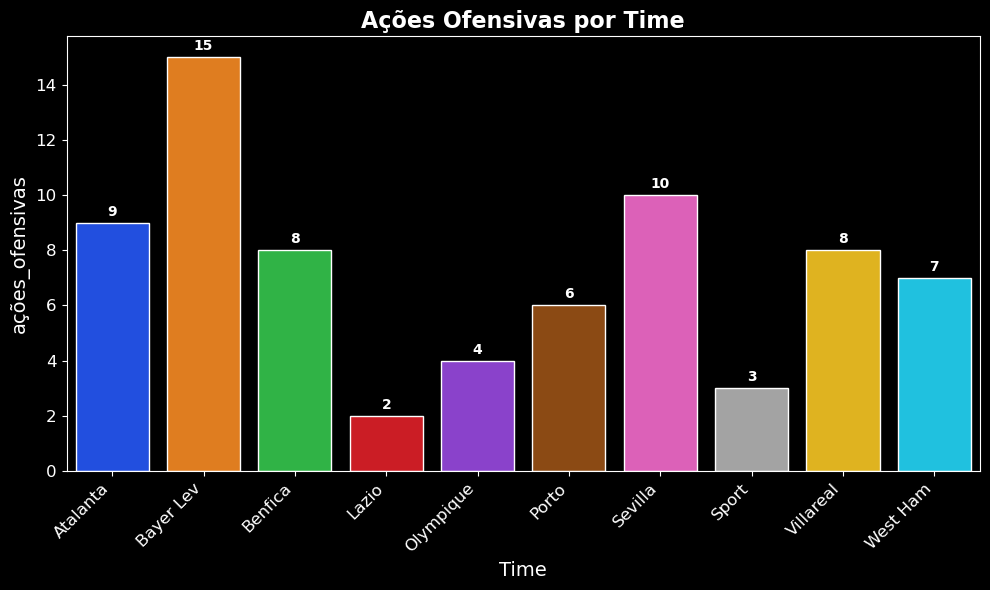

In [6]:
#grafico das ações ofensivas por time
imagem = plot_bar_chart(time,'ações_ofensivas','Ações Ofensivas por Time')
# Salvando o gráfico em um arquivo PNG
imagem.savefig('acoes_ofensivas.png', dpi=300, bbox_inches='tight')

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\AppData\Local\Temp\ipykernel_10728\3554975081.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, color='white')


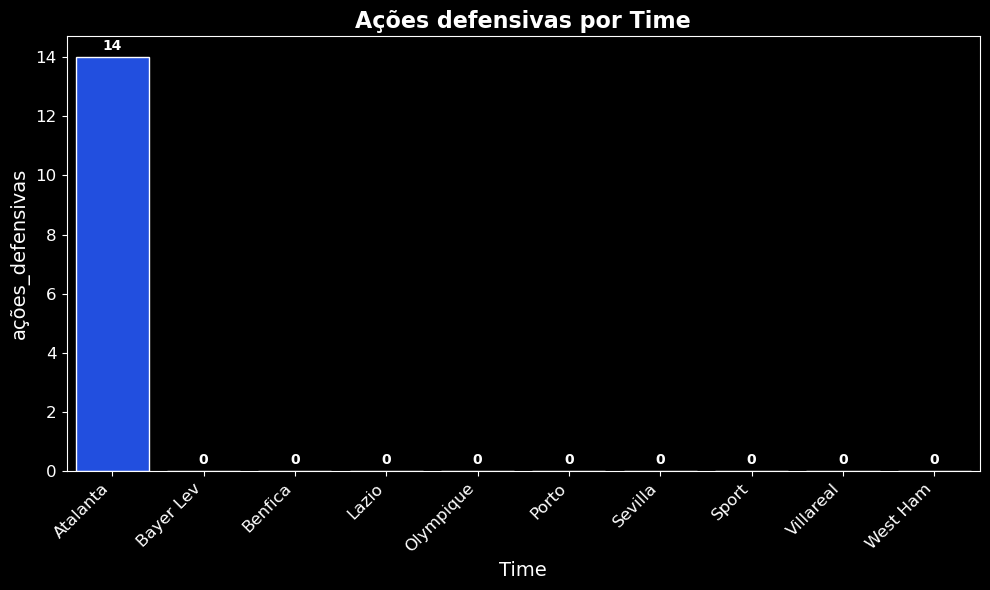

In [7]:
#grafico das ações defensivas por time
imagem = plot_bar_chart(time,'ações_defensivas','Ações defensivas por Time')
# Salvando o gráfico em um arquivo PNG
imagem.savefig('acoes_defensivas.png', dpi=300, bbox_inches='tight')

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\AppData\Local\Temp\ipykernel_10728\3554975081.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, color='white')


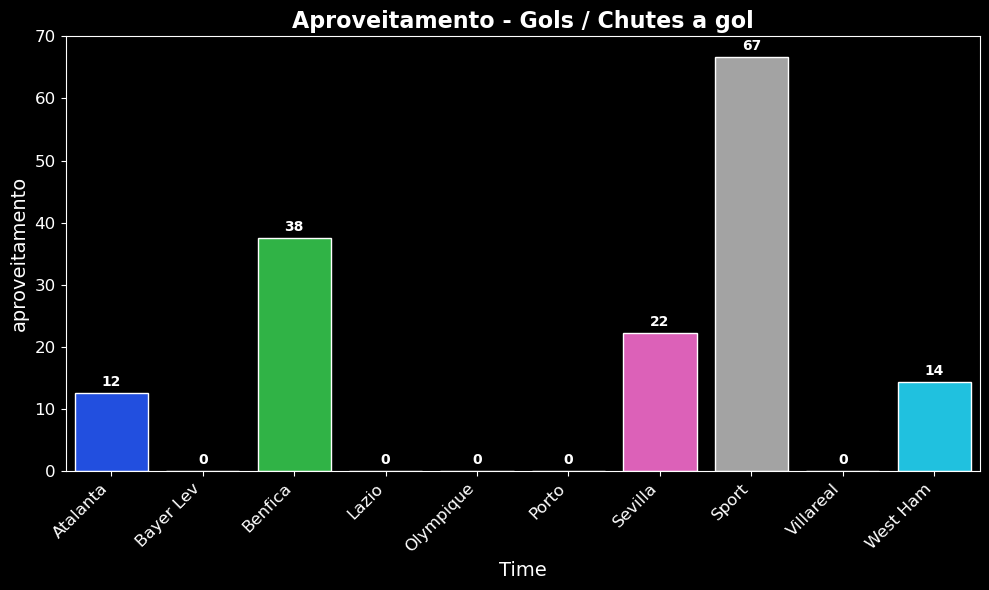

In [8]:
#grafico do aproveitamento por time
imagem = plot_bar_chart(time,'aproveitamento','Aproveitamento - Gols / Chutes a gol')
# Salvando o gráfico em um arquivo PNG
imagem.savefig('aproveitamento.png', dpi=300, bbox_inches='tight')

In [9]:
#informações relevantes da rodada
total_gols = df.gol.sum()
total_ass = df.assistencia.sum()
cartoes = df.amarelo.sum() + df.vermelho.sum()
acoes_def = time.ações_defensivas.sum()
acoes_ofen = time.ações_ofensivas.sum()
total_defesas = df2.defesas.sum()

In [10]:
def card(value, title, filename):
    """
    Cria um card com um número e um título.

    Args:
        value (str or int): Valor a ser exibido no card.
        title (str): Título do card.
        filename (str): Nome do arquivo para salvar a imagem do card.
    """
    # Criar uma nova figura
    fig, ax = plt.subplots(figsize=(4, 2))  # Ajuste o tamanho conforme necessário
    ax.axis('off')  # Desligar o eixo

    # Adicionar o texto do título e do valor ao card
    ax.text(0.5, 0.6, f'{value}', fontsize=30, ha='center', va='center', weight='bold')
    ax.text(0.5, 0.4, title, fontsize=14, ha='center', va='center', color='gray')

    # Ajustar estilo
    plt.gca().set_facecolor('black')  # Cor de fundo do card
    plt.gca().patch.set_edgecolor('white')  # Cor da borda

    # Salvar a imagem
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1, transparent=True)

    # Exibir a imagem (opcional)
    plt.show()

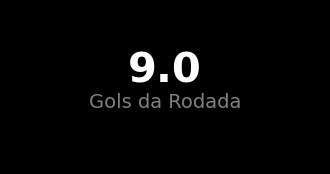

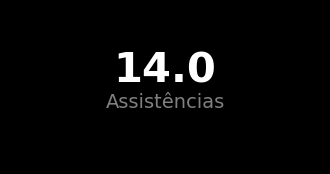

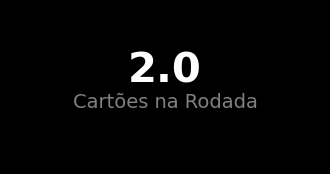

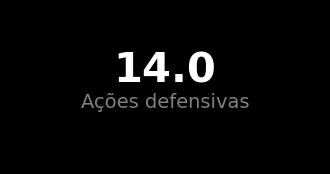

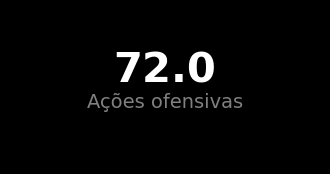

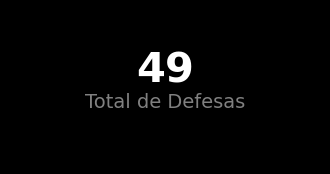

In [11]:
card(total_gols,'Gols da Rodada','total_gols')
card(total_ass,'Assistências','total_ass')
card(cartoes,'Cartões na Rodada','total_cartoes')
card(acoes_def,'Ações defensivas','total_defensivas')
card(acoes_ofen,'Ações ofensivas','total_ofen')
card(total_defesas,'Total de Defesas','defesas_goleiros')

In [12]:
df

,time,nome,numero,jogou,gol,assistencia,desarme,interceptacao,falta sofrida,falta cometida,trave,amarelo,vermelho,pontuação
0,Atalanta,leo wender,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0
1,Atalanta,Pogba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Atalanta,marcello,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Atalanta,lucas martins,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Atalanta,rica,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,Porto,hugo santos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
116,Sevilla,mi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
117,Sport,salermo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
118,Villareal,pico,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [13]:
#goleiros que mais realizaram defesas top5
defesas_gol = df2[['time','nome','defesas']].sort_values('defesas',ascending=False)[:5].reset_index(drop=True)
#jogadores que mais marcaram gols top5
jogadores_gol = df[['time','nome','gol']].sort_values('gol',ascending=False)[:5].reset_index(drop=True)
#jogadores que mais desarmaram
df['ações_defensivas'] = df.interceptacao + df.desarme
jogadores_defensiva = df[['time','nome','ações_defensivas']].sort_values('ações_defensivas',ascending=False)[:5].reset_index(drop=True)
#top10 pontuadores da rodada
top_10_pont = df[['time','nome','pontuação']].sort_values('pontuação',ascending=False)[:10].reset_index(drop=True)

In [14]:
def plot_bar2(time_df, x_col, y_col, hue_col, title):
    """
    Plota um gráfico de barras com fundo preto e texto branco, usando o parâmetro hue.

    Args:
        time_df (pd.DataFrame): DataFrame contendo os dados.
        x_col (str): Nome da coluna para o eixo x.
        y_col (str): Nome da coluna para o eixo y.
        hue_col (str): Nome da coluna para a variável hue (categorias).
        title (str): Título do gráfico.
    
    Returns:
        fig (matplotlib.figure.Figure): Objeto Figure contendo o gráfico.
    """
    # Definindo um estilo personalizado para o fundo preto
    plt.style.use("dark_background")

    # Criando a figura e o eixo
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plotando o gráfico de barras com fundo preto
    sns.barplot(x=x_col, y=y_col, hue=hue_col, data=time_df, ax=ax, edgecolor="white")

    # Adicionando rótulos no topo de cada barra com texto branco
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 8), textcoords='offset points',
                    fontsize=10, color='white', weight='bold')

    # Melhorando a visualização com texto branco
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12, color='white')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, color='white')
    ax.set_title(title, fontsize=16, weight='bold', color='white')
    ax.set_xlabel(x_col, fontsize=14, color='white')
    ax.set_ylabel(y_col, fontsize=14, color='white')
    plt.tight_layout()

    # Retornando o objeto Figure
    return fig

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

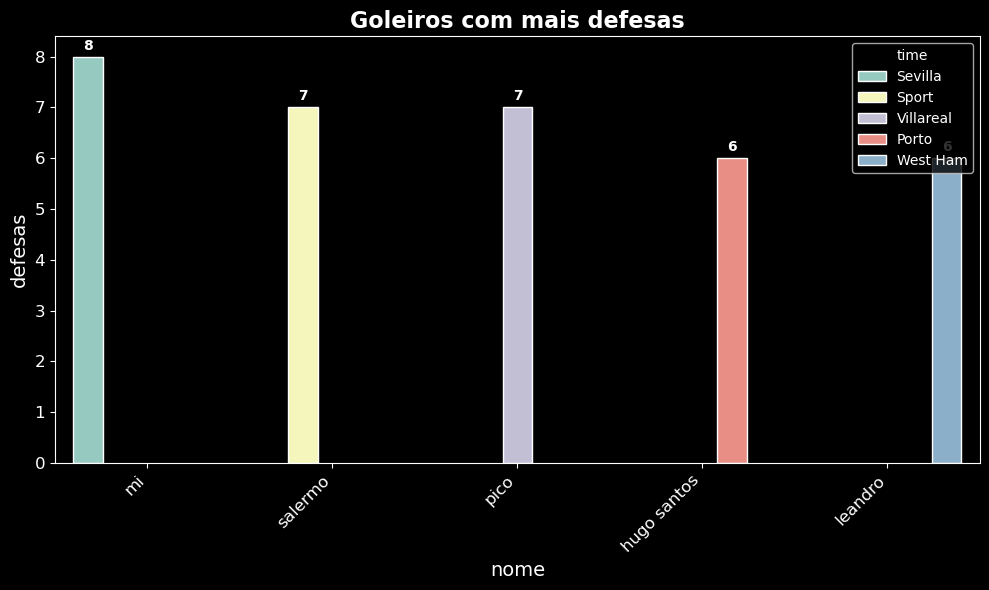

In [15]:
#grafico goleiros
fig = plot_bar2(defesas_gol,'nome','defesas','time','Goleiros com mais defesas')
fig.savefig('goleiros.png')

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

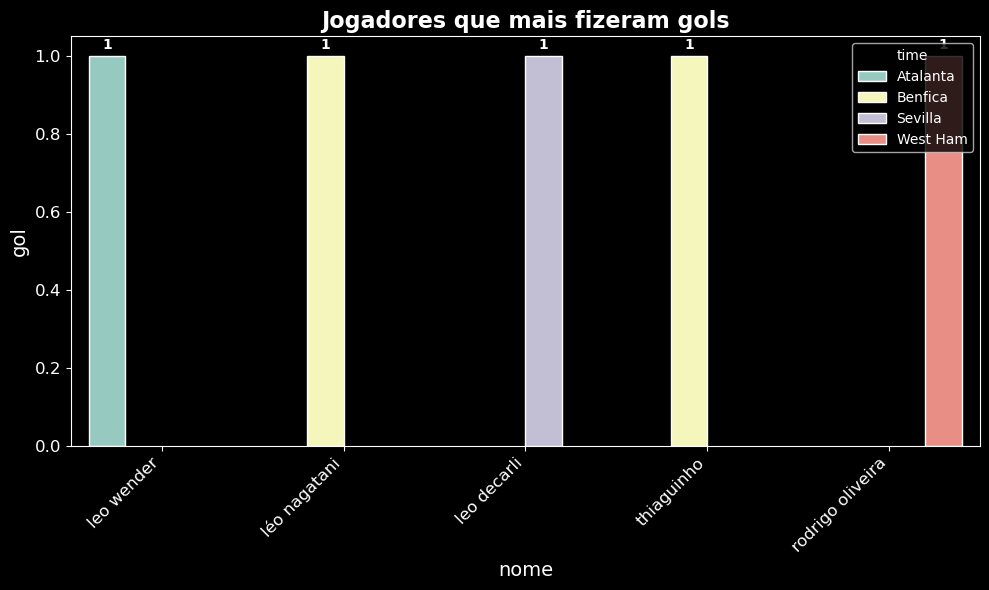

In [16]:
#grafico artilheiros
fig = plot_bar2(jogadores_gol,'nome','gol','time','Jogadores que mais fizeram gols')
fig.savefig('gols.png')

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

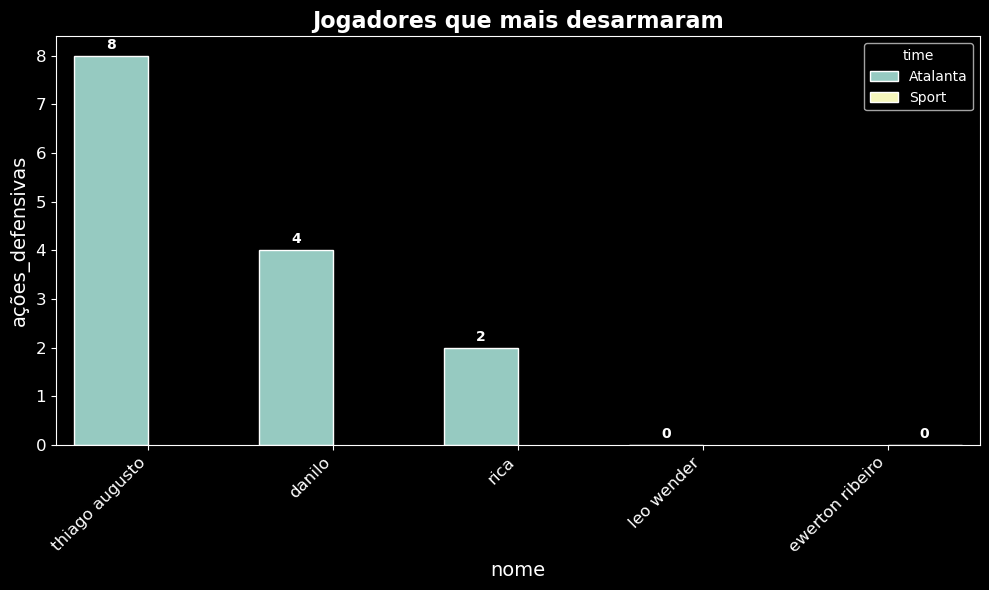

In [17]:
#jogadores com mais ações defensivas
fig = plot_bar2(jogadores_defensiva,'nome','ações_defensivas','time','Jogadores que mais desarmaram')
fig.savefig('ações_defensvias.png')

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

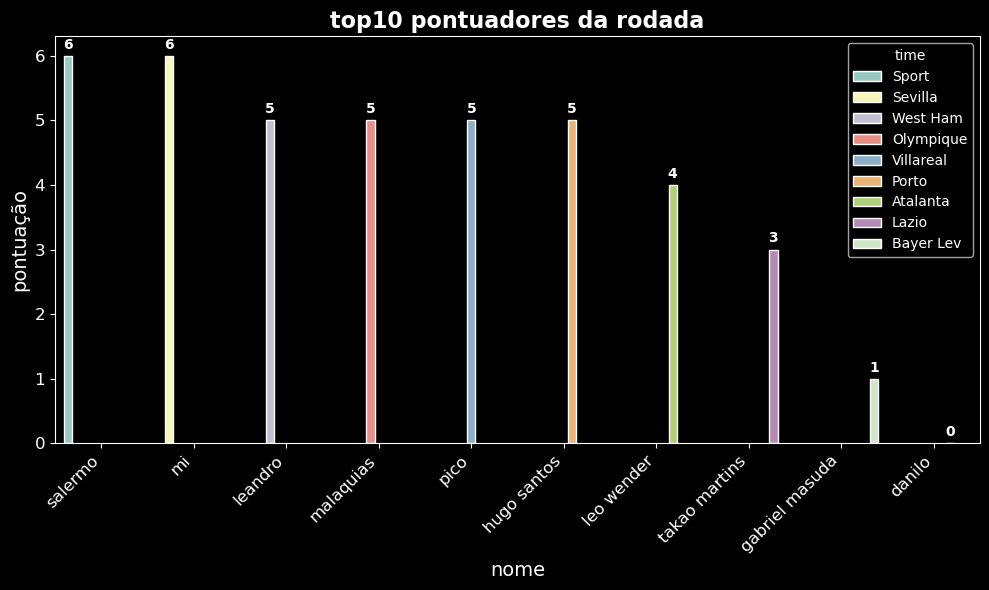

In [18]:
#top10 pontuadores da rodada
fig = plot_bar2(top_10_pont,'nome','pontuação','time','top10 pontuadores da rodada')
fig.savefig('pontuação.png')

In [19]:
def create_dashboard(cards_images, graphs_images, title, output_file):
    """
    Cria um dashboard com gráficos maiores à esquerda e cards menores à direita e salva como um arquivo PDF.

    Args:
        cards_images (list of str): Lista de caminhos para as imagens dos cards menores.
        graphs_images (list of str): Lista de caminhos para as imagens dos gráficos maiores.
        title (str): Título do dashboard.
        output_file (str): Nome do arquivo para salvar o PDF do dashboard.
    """
    num_cards = len(cards_images)
    num_graphs = len(graphs_images)
    
    # Configura o layout da figura
    fig, axs = plt.subplots(nrows=max(num_cards, num_graphs), ncols=2, figsize=(15, max(num_cards, num_graphs) * 5))
    
    # Define o fundo da figura como preto
    fig.patch.set_facecolor('black')

    axs = axs.flatten()  # Achatar a matriz de eixos

    # Adicionar o título
    plt.suptitle(title, fontsize=20, weight='bold', color='white', backgroundcolor='black')

    # Adicionar os gráficos maiores à coluna da esquerda
    for i in range(num_graphs):
        axs[i * 2].imshow(mpimg.imread(graphs_images[i]))
        axs[i * 2].axis('off')  # Desligar os eixos
        axs[i * 2].set_facecolor('black')  # Definir o fundo dos eixos como preto

    # Adicionar os cards menores à coluna da direita
    for j in range(num_cards):
        axs[j * 2 + 1].imshow(mpimg.imread(cards_images[j]))
        axs[j * 2 + 1].axis('off')  # Desligar os eixos
        axs[j * 2 + 1].set_facecolor('black')  # Definir o fundo dos eixos como preto

    # Desligar os eixos restantes se houver menos imagens
    for k in range(len(graphs_images) + len(cards_images), len(axs)):
        axs[k].axis('off')
        axs[k].set_facecolor('black')  # Definir o fundo dos eixos como preto

    # Ajustar layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajustar o layout para o título não sobrepor as imagens

    # Salvar o dashboard como PDF
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0.1, format='pdf', facecolor='black')

    # Exibir a imagem (opcional)
    plt.show()

In [20]:
# Lista de caminhos para as imagens dos cards e gráficos
cards_images = [
    'total_gols.png',
    'total_ass.png',
    'total_defensivas.png',
    'total_ofen.png',
    'total_cartoes.png',
    'defesas_goleiros.png'
]

graphs_images = [
    'acoes_defensivas.png',
    'acoes_ofensivas.png',
    'aproveitamento.png',
    'ações_defensvias.png',
    'gols.png',
    'pontuação.png',
]

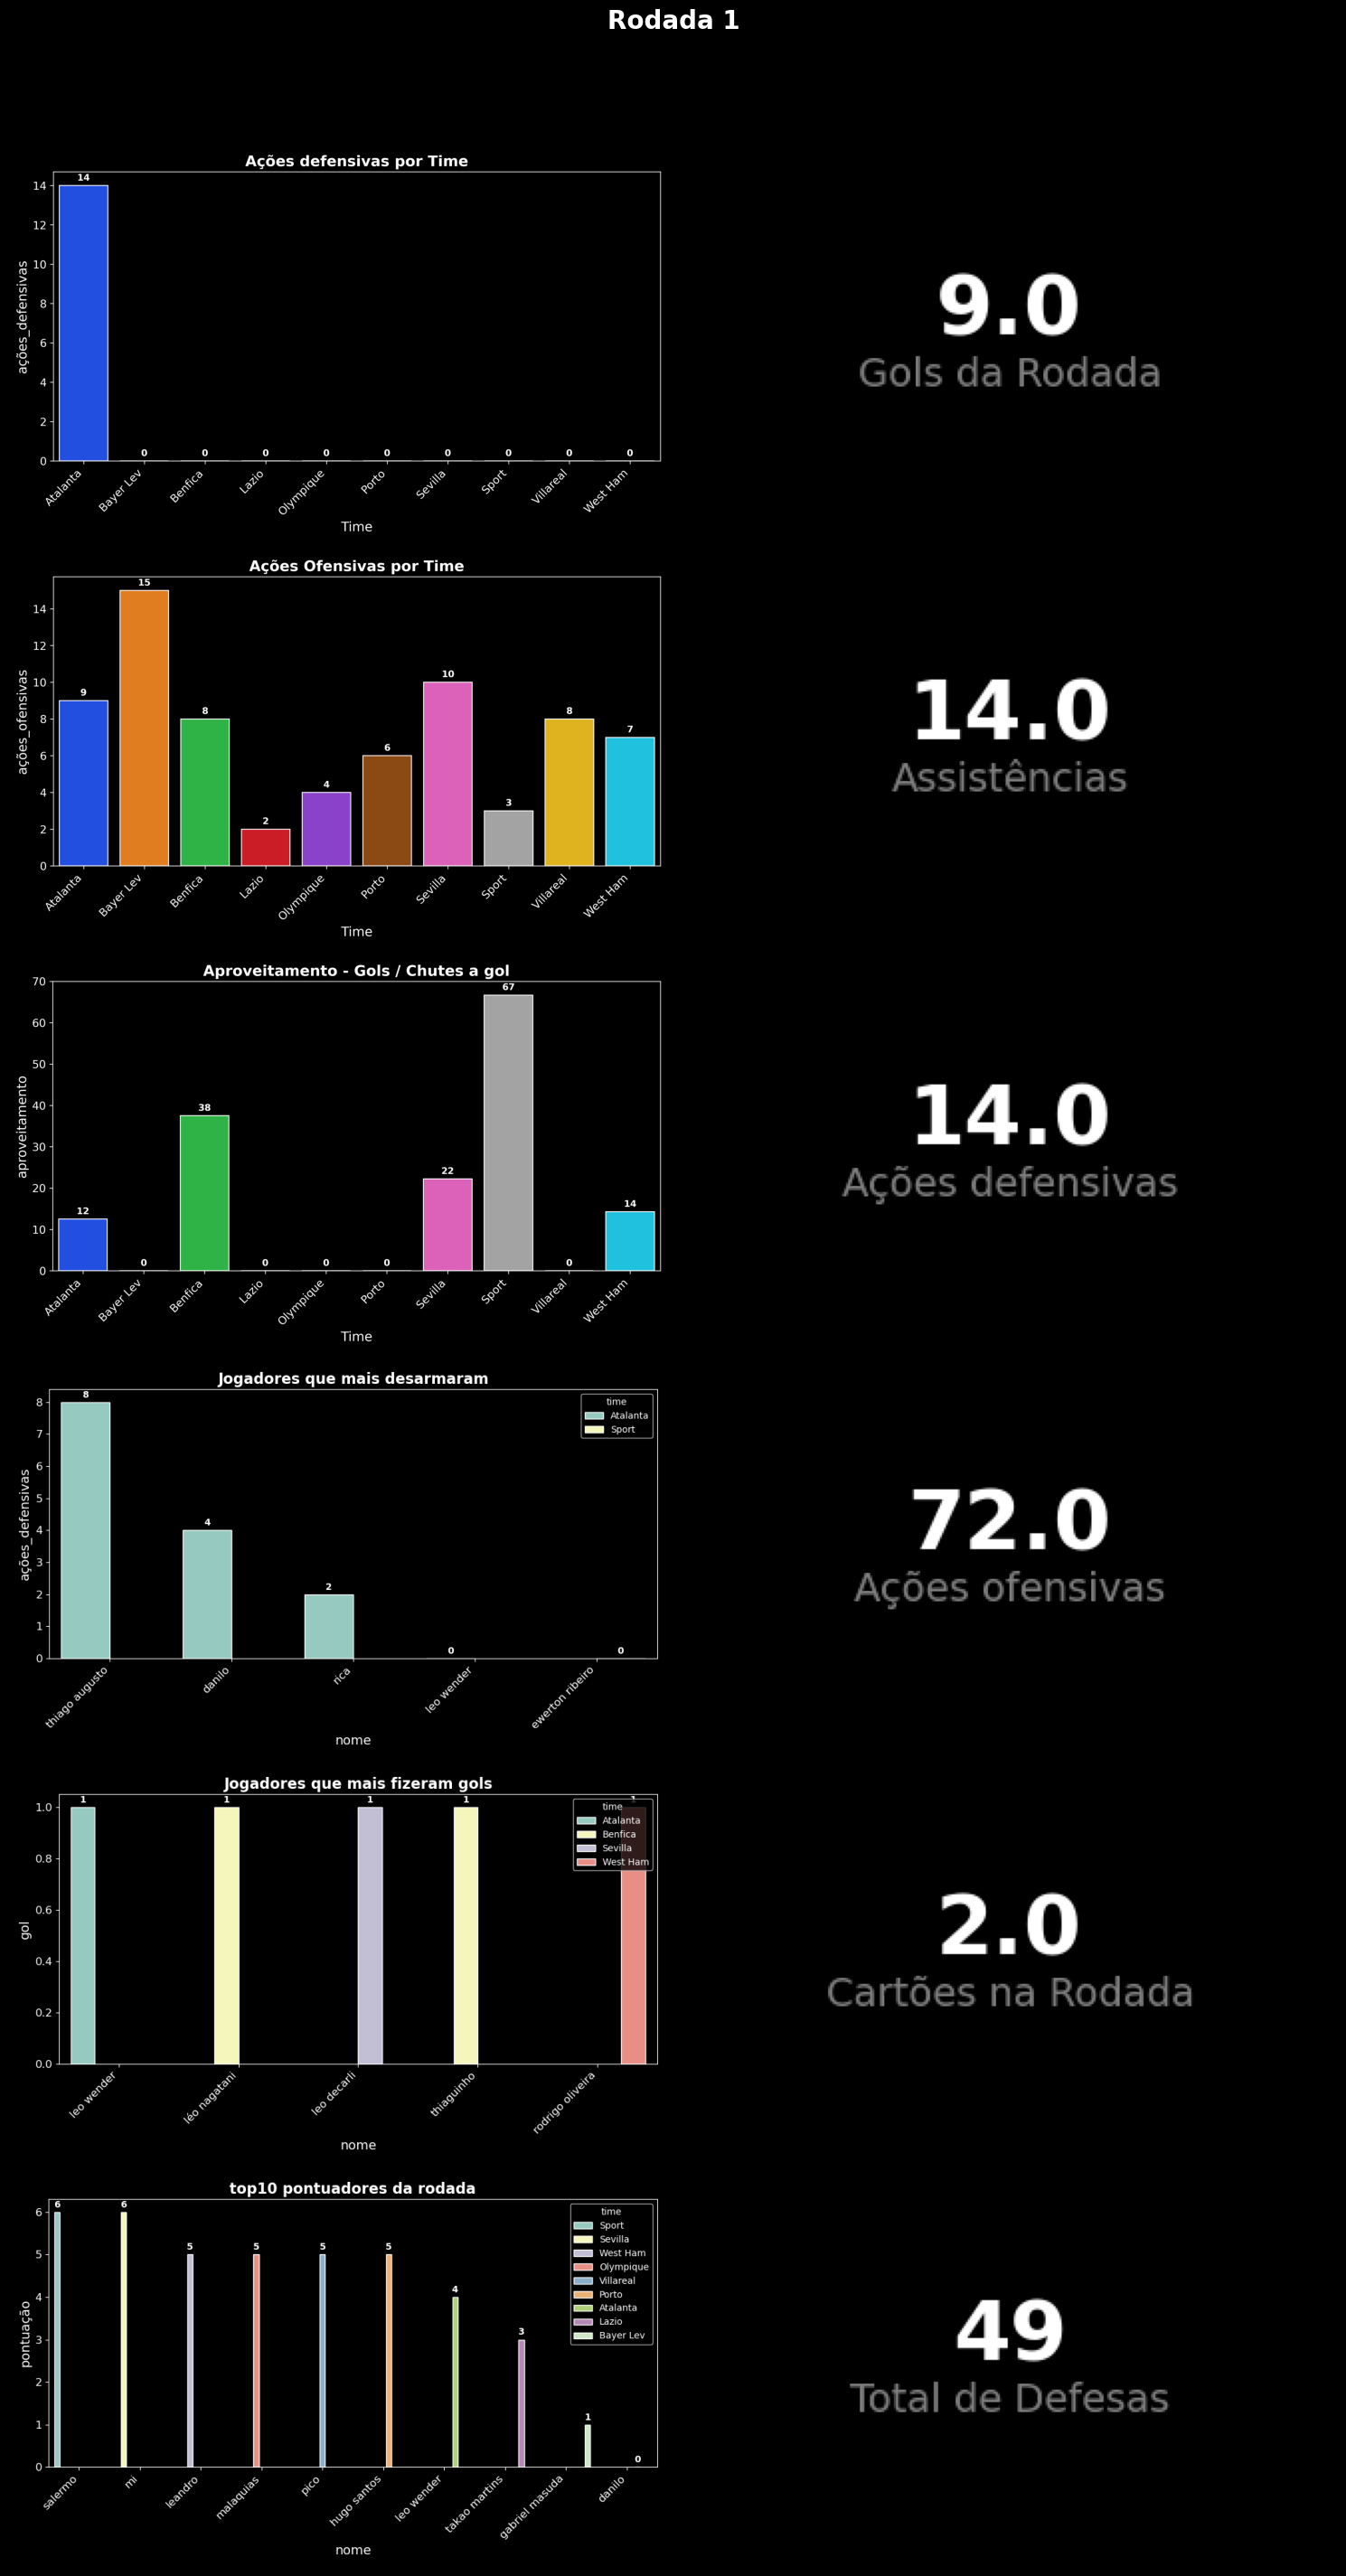

In [21]:
create_dashboard(cards_images,graphs_images,'Rodada 1','dash.pdf')

In [22]:
df.to_excel('jogadores.xlsx',index=False)
df2.to_excel('goleiros.xlsx',index=False)
time.to_excel('time.xlsx',index=False)